In [280]:
import os
import subprocess
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from time import time as t
from numba import jit

import json
# import io

# import datetime

import astropy
import astropy.units as u
import astropy.constants as c
import astropy.cosmology

# from IPython.display import Image, display_png

from astroquery.simbad import Simbad

import photontools

from IPython.display import display
import matplotlib.colors as colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import mosfit
import corner
# import json
# import matplotlib.pyplot as plt
# import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook
from collections import OrderedDict
from mosfit.plotting import bandcolorf


In [281]:
%matplotlib inline
# %matplotlib notebook

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 15
plt.rcParams["figure.dpi"] = 150

lss = ['-', '--', '-.', ':']

In [282]:
filepath_hewd = "../../hewd_hr/gamtmp.d"
filepath_cowd = "../../cowd100x50x50/gamtmp.d"

directory_ML = "/Users/kawana/GoogleDrive/sync/study/yoshidalab/mypaper/0002_WD_TDE_radiation_transfer/WhiteDwarf_Thermonuclear_Transients/"
filepaths_spectra_ML = subprocess.getoutput('find "{}/WD06_spectra/" | grep ".par" | sort'.format(directory_ML)).split("\n")[1:]

vel_cowd = np.array([2.56466437e+03, 1.18143578e+04, -1.41779372e+00]) * 1e5
vel_hewd = np.array([4.49999438e+03, 1.54867843e+04, 1.27477734e+01]) * 1e5
# f_ = open(filepath_, mode="r") 

In [283]:
class Transient(object):
    def __init__(self):
        self.name = None
        self.instrument = None
        self.Nphoton = None
        self.redshift = None
        self.luminosity_distance = None
        self.Eb_v = None
        self.maxdate = None
        self.bands = None
        self.data = None # flux/mag with the same order as self.bands [N_band][N_time, 3] 3: time, flux/mag, error of flux/mag
        self.spectra = None # just for stock json data

In [284]:
def calc_model_lc(spectra, transient, filter, convert_to_magnitude=False):
    spectra_ = copy.deepcopy(spectra)
    spectra_ = spectra_.redshift(z=transient.redshift)
    spectra_ = spectra_.dust_extinction(Eb_v = transient.Eb_v, model="maeda")
    lc = photontools.calc_band_flux(spectra_, filter)
    if (convert_to_magnitude):
        if (u.get_physical_type((transient.luminosity_distance * u.m / u.m).unit) == "length"):
            lc = lc.convert_flux_to_magnitude(filter, system="AB", distance=transient.luminosity_distance)
        elif (u.get_physical_type((transient.luminosity_distance * u.m / u.m).unit) == "dimensionless"):
            lc = lc.convert_flux_to_magnitude(filter, system="AB", distance=transient.luminosity_distance * u.Mpc)
        else:
            raise ValueError("Input luminosity_distnace unit is wrong!")
    else:
        lc.data = lc.data / (4 * np.pi * transient.luminosity_distance.cgs.value**2)
    return lc

# preprocess spectra

In [285]:
%time spectra_hewd = photontools.read_Maeda_data(filepath_hewd)
%time spectra_cowd = photontools.read_Maeda_data(filepath_cowd)

CPU times: user 6.74 s, sys: 12.7 s, total: 19.4 s
Wall time: 25.5 s
CPU times: user 5.16 s, sys: 9.72 s, total: 14.9 s
Wall time: 16.8 s


In [286]:
%time spectra_hewd = spectra_hewd.binning(N_theta_bins=10, N_phi_bins=10)
%time spectra_cowd = spectra_cowd.binning(N_theta_bins=10, N_phi_bins=10)
%time spectra_hewd = spectra_hewd.Doppler_shift_by_intrinsic_velocity(vel_hewd)
%time spectra_cowd = spectra_hewd.Doppler_shift_by_intrinsic_velocity(vel_cowd)


CPU times: user 4.36 s, sys: 3.2 s, total: 7.56 s
Wall time: 8.5 s
CPU times: user 3.45 s, sys: 2.45 s, total: 5.9 s
Wall time: 6.53 s
This Doppler shift only changes spectra.data!
Shift spectra.time later by yourself!
CPU times: user 1.21 s, sys: 108 ms, total: 1.32 s
Wall time: 1.39 s
This Doppler shift only changes spectra.data!
Shift spectra.time later by yourself!
CPU times: user 1.13 s, sys: 82.5 ms, total: 1.21 s
Wall time: 1.25 s


# DES
Pursiainen+ 18

In [287]:
filter_decam = photontools.read_one_instrument_filters("./photontools/filter_data/decam/")

In [288]:
# bands_from_blue = np.array(["UVW2", "UVM2", "UVW1", "U", "B", "V", "R", "I", "J", "H", "K"])
# color_from_blue = np.array([plt.cm.jet(i/bands_from_blue.size) for i in range(bands_from_blue.size)])
# dict_color = dict(zip(bands_from_blue, color_from_blue))

bands_from_blue = np.array(["g", "r", "i", "z"])
color_from_blue = np.array([plt.cm.jet(i/bands_from_blue.size) for i in range(bands_from_blue.size)])
#     color_from_blue = np.array([plt.cm.viridis(i/bands_from_blue.size) for i in range(1, bands_from_blue.size+1)])
dict_color = dict(zip(bands_from_blue, color_from_blue))


In [289]:
filepath_catalog_lc = "/Users/kawana/GoogleDrive/sync/study/yoshidalab/mypaper/0002_WD_TDE_radiation_transfer/catalog/fast_transients/Pursiainen_2018_DES/header_gold+silver_samples.txt"
dir_catalog_lc = '/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/photons/0002_WD_TDE_radiation_transfer/catalog/fast_transients/Pursiainen_2018_DES/LCs/'


In [290]:
# columns_ = ["category", "name", "yaer", "month", "day", "ra_h", "ra_min", "ra_s", 
#             "dec_deg", "dec_arcmin", "dec_arcsec", 
#             "z", "distance", 
#             "lambdag", "lambdar", "lambdai", "lambdaz", "Eb_v"]
# df_catalog_head = pd.read_csv(filepath_catalog_head, delim_whitespace=True, header = None, names=columns_)
df_catalog_head = pd.read_csv(filepath_catalog_head, delim_whitespace=True)
# df_catalog_head.replace("---", np.nan, inplace=True)
# df_catalog_head[columns_[11:]] = df_catalog_head[columns_[11:]].astype(float)
# df_catalog_head = df_catalog_head[[st in ["A", "B"] for st in df_catalog_head["category"]]]
df_catalog_head

name  survey  offset(arcsec)  offset(kpc)   DLR  zspec  zphot  \
0    DES13X1hav   OzDES           0.381         2.51  0.90   0.58   0.64   
1    DES13X3gms   OzDES           0.879         6.09  1.13   0.65   0.64   
2    DES14C3tvw    ACES           3.703        26.46  3.71   0.70   0.70   
3    DES14S2anq    SDSS           0.377         0.37  0.34   0.05   0.08   
4    DES14S2plb   OzDES           1.506         3.26  1.82   0.12   0.13   
5    DES14S2pli   OzDES           1.623         8.01  2.24   0.35   0.39   
6    DES14X3pkl   OzDES           0.281         1.25  0.52   0.30   0.43   
7    DES15C3lpq   OzDES           0.323         2.18  0.44   0.61   0.62   
8    DES15C3mgq   OzDES           0.207         0.76  0.38   0.23   0.26   
9    DES15E2nqh   OzDES           0.517         3.22  1.41   0.52   0.46   
10   DES15S1fli   OzDES           0.771         4.44  0.81   0.45   0.46   
11   DES15S1fll   OzDES           2.997        11.01  3.50   0.23   0.21   
12   DES15X3mxf   OzDES           1.726         9.81  3.14   0.44   0.43   
13   DES16C1cbd   OzDES           1.075         6.83  1.21   0.54   0.54   
14   DES16C2ggt  PRIMUS           1.462         6.66  1.98   0.31   0.35   
15   DES16E1bir       –           0.341         2.89  1.11   1.56   0.53   
16    DES16E2pv   OzDES           1.081         7.85  1.84   0.73   0.82   
17   DES16S1dxu   OzDES           4.120        10.16  4.87   0.14   0.13   
18   DES16X1eho  PRIMUS           0.425         3.13  0.72   0.76   0.82   
19   DES16X3cxn   OzDES           0.626         4.12  1.00   0.58   0.64   
20   DES13C1tgd   OzDES           0.399         1.32  0.41   0.20   0.32   
21  DES13C3bcok     AAT           0.791         3.91  0.39   0.35   0.30   
22   DES13C3uig    ACES           0.542         3.80  0.78   0.67   0.66   
23   DES13E2lpk   OzDES           0.799         4.77  0.79   0.48   0.38   
24   DES13X3npb   OzDES           0.173         1.06  0.16   0.50   0.37   
25   DES13X3nyg   OzDES           0.410         2.95  0.75   0.71   0.68   
26   DES13X3pby   OzDES           0.337         2.67  0.75   0.96   0.41   
27   DES14X1bnh   OzDES           0.452         3.44  0.68   0.83   0.80   
28   DES15C2eal   OzDES           2.443         8.68  5.50   0.22   0.26   
29   DES15C3lzm   ATLAS           0.511         2.43  0.47   0.33   0.30   
30   DES15C3nat   OzDES           0.592         4.52  1.16   0.84   0.81   
31   DES15C3opk   OzDES           0.523         3.41  0.76   0.57   0.59   
32   DES15C3opp   OzDES           0.429         2.44  0.83   0.44   0.37   
33   DES15X2ead   OzDES           0.545         2.00  0.65   0.23   0.25   
34   DES16C3axz     AAT           0.336         1.23  0.44   0.23   0.21   
35   DES16C3gin   OzDES           1.606         7.93  1.87   0.35   0.41   
36   DES16X3ega    GAMA           2.219         8.93  2.17   0.26   0.19   

      RA(J2000)    Dec(J2000)    Eb_v  
0   02:20:07.80  −05:06:36.53  0.0185  
1   02:23:12.27  −04:29:38.35  0.0246  
2   03:33:17.61  −27:54:23.92  0.0058  
3   02:45:06.67  −00:44:42.77  0.0294  
4   02:47:25.62  −01:37:06.91  0.0369  
5   02:44:54.76  −01:05:52.74  0.0256  
6   02:28:50.64  −04:48:26.44  0.0332  
7   03:30:50.89  −28:36:47.08  0.0078  
8   03:31:04.56  −28:12:31.74  0.0080  
9   00:38:55.59  −43:05:13.14  0.0076  
10  02:52:45.15  −00:53:10.21  0.0675  
11  02:51:09.36  −00:11:48.71  0.0611  
12  02:26:57.72  −05:14:22.81  0.0237  
13  03:39:25.97  −27:40:20.37  0.0100  
14  03:35:33.88  −29:13:29.33  0.0089  
15  00:30:58.64  −42:58:37.18  0.0064  
16  00:36:50.19  −43:31:40.16  0.0059  
17  02:50:43.53  −00:42:33.29  0.0486  
18  02:21:22.87  −04:31:32.64  0.0229  
19  02:27:19.32  −04:57:04.27  0.0234  
20  03:36:15.42  −27:38:19.07  0.0105  
21  03:32:06.47  −28:37:29.70  0.0081  
22  03:31:46.55  −27:35:07.96  0.0073  
23  00:40:23.80  −43:32:19.74  0.0058  
24  02:26:34.11  −04:08:01.96  0.0242  
25  02:27:58.17  −03:54:48.05  0.0233  
26  02:25:19.98  −05:18:50.58  0.0223  
27

In [291]:
def read_decam_one_transient(name, df_header, directory_light_curves=None, cosmo=None):
    """
    return Transient with the given name and df_header

    arguments
    =========
    cosmo: type: astropy.cosmology. If None, we will use it given astropy.cosmology.Planck15. 
                 used to calc luminosity distance
    """
    
    def assign_luminosity_distance(redshift, cosmo):
        return cosmo.luminosity_distance(redshift)
        
    if directory_light_curves is None:
        directory_light_curves = "/Users/kawana/GoogleDrive/sync/study/yoshidalab/tidal_disruption/imbh-wd/nuclear/std/compare/snaps/successed/photons/0002_WD_TDE_radiation_transfer/catalog/fast_transients/Pursiainen_2018_DES/LCs/"
    if cosmo is None:
        cosmo = astropy.cosmology.Planck15
    
    df_this = df_header[df_header["name"] == name].iloc[0]
    transient = Transient()
    transient.name = name
    transient.redshift = df_this["zspec"]
    transient.luminosity_distance = assign_luminosity_distance(transient.redshift, cosmo)
    transient.Eb_v = df_this["Eb_v"]
    transient.bands = np.array(["g", "r", "i", "z"])
    
    transient.data = [[]] * transient.bands.size
    
    for i, band in enumerate(transient.bands):
        fpath = directory_light_curves + "/" + name + "_" + band + ".dat"
        data_ = np.loadtxt(fpath)
        data2_ = data_.T
        data2_[1:] = data2_[1:] * 1e-18
        transient.data[i] = data2_
    
    return transient

def replace_MJD_to_rest_frame_day_after_peak(transient:Transient, band="g"):
    new_transient = copy.deepcopy(transient)
        
    mask_ = transient.bands == band
    index_of_the_band = np.arange(mask_.size)[mask_][0]
    index_of_band_peak = np.argmax(transient.data[index_of_the_band][1])
    date_peak = transient.data[index_of_the_band][0][index_of_band_peak]
    
    for i in range(len(transient.data)):
        new_transient.data[i][0] = (transient.data[i][0] - date_peak) / (1 + transient.redshift)
    
    return new_transient


In [344]:
spectra_hewd.times[9]

array([ 1.62181011,  1.69824366,  1.77827942,  1.86208714,  1.9498446 ,
        2.04173795,  2.13796209,  2.23872114,  2.34422881,  2.45470891,
        2.57039577,  2.69153479,  2.81838291,  2.95120921,  3.09029541,
        3.23593654,  3.38844153,  3.54813385,  3.71535225,  3.8904514 ,
        4.07380272,  4.26579512,  4.46683585,  4.67735133,  4.8977881 ,
        5.12861374,  5.37031785,  5.62341313,  5.88843642,  6.16594987,
        6.45654213,  6.76082958,  7.07945766,  7.41310221,  7.76247094,
        8.12830492,  8.51138012,  8.9125091 ,  9.3325427 ,  9.77237188,
       10.23292957, 10.71519267, 11.22018413, 11.7489751 , 12.30268723,
       12.882495  , 13.48962827, 14.12537485, 14.79108324, 15.48816551,
       16.21810024, 16.98243574, 17.78279326, 18.62087047, 19.49844504,
       20.41737842, 21.3796198 , 22.38721021, 23.4422869 , 24.54708782,
       25.7039564 , 26.91534652, 28.18382769, 29.51209054, 30.90295249,
       32.35936373, 33.88441353, 35.4813367 , 37.15352054, 38.90

In [345]:
transient_.name

'DES16X3ega'

In [346]:
lc_ = calc_model_lc(spectra_hewd, transient_, filter_decam)

In [347]:
lc_ = lc_.binning(every_time=1, N_theta_bins=1, N_phi_bins=1, )

In [350]:
lc_.data.shape

(86, 1, 1, 5)

In [352]:
a_ = np.zeros(0, dtype=float)

In [354]:
np.append(a_, 1)

array([1.])

In [356]:
def 

def fit_obs(lc_mean, trnasient, enable_amplify_monochromatic=False, enable_time_shift=True):
    fit_params = {}
    
    if (enable_monotomic_amplify):
        fit_params["amplify_monochromatic"] = 1.
    if (enable_time_shift):
        fit_params["time_shift"] = 0.
        
    return fit_params

In [358]:
a_ = fit_obs(1, 2, enable_amplify=True)

dict_keys(['amplify', 'time_shift'])

In [292]:
def plot_decam_transient(fig, ax, transient):
    
    for i, band in enumerate(transient.bands):
        # detection
        ax.errorbar(transient.data[i][0], transient.data[i][1], transient.data[i][2], color=dict_color[band], label=band, fmt="o")
# #         upper limit
#         df_ = transient.data[i][transient.data[i]["mag_upper"]]
#         ax.errorbar(df_["Phase"], df_["mag"], fmt="v", color=dict_color[band], label="")        
    return fig, ax

def plot_model(fig, ax, spectra, transient, time_shift = 0., **keys):
    
    lc = calc_model_lc(spectra, transient, filter_decam)[9:]
    
    for i, theta in enumerate(lc.thetas):
        for j, phi in enumerate(lc.phis):
            for k, band in enumerate(lc.bands):
                if band != "y" and band != "Y":
                    ax.plot((lc.times - time_shift) * lc.Doppler_shift_intrinsic[i,j], lc.data[:,i,j,k], color=dict_color[band], **keys)
    return fig, ax


def plot_model_with_fit(fig, ax, spectra, transient_, time_shift = 0., **keys):
    
    # redshift and dust_extinction
    lc = calc_model_lc(spectra, transient, filter_decam)[9:]
    
    lc_mean = lc.binning(every_time=1, N_theta_bins=1, N_phi_bins=1)
    
    for i, theta in enumerate(lc.thetas):
        for j, phi in enumerate(lc.phis):
            for k, band in enumerate(lc.bands):
                if band != "y" and band != "Y":
                    ax.plot((lc.times - time_shift) * lc.Doppler_shift_intrinsic[i,j], lc.data[:,i,j,k], color=dict_color[band], **keys)
    return fig, ax



In [314]:
def plot_one_transient_obs_and_model(fig, ax, transient, spectra, time_shift, savefig=False, **keys):

    fig, ax = plot_decam_transient(fig, ax, transient)

    xlim_ = ax.get_xlim()
    ylim_ = ax.get_ylim()
    
    plot_model(fig, ax, spectra, transient, time_shift=time_shift, **keys)

    plt.xlim(xlim_)
    # plt.ylim(ylim_)

    plt.yscale("log")
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    plt.grid()
    plt.legend()
    plt.title(transient.name + " (z = {:.2f})".format(transient.redshift))
    plt.xlabel(r"Rest frame days since g$_{\rm max}$")
    plt.ylabel(r"Flux [$10^{-18}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]")
    if (transient.name != "DES14S2anq"):
        plt.ylim(1e-20, 1e-17)
    else:
        plt.ylim(1e-19, 1e-16)
    if (savefig):
        fig.tight_layout()
        plt.savefig("figs/obs/rapid/Pursiainen_2018/{}.pdf".format(transient.name), dpi=300, transparent=True)
    plt.show()
    plt.close()
    return

def plot_one_transient_obs_and_model_with_fit(fig, ax, transient, spectra, time_shift, savefig=False, enable_amplify=False, **keys):

    fig, ax = plot_decam_transient(fig, ax, transient)

    xlim_ = ax.get_xlim()
    ylim_ = ax.get_ylim()
    
    plot_model(fig, ax, spectra, transient, time_shift=time_shift, **keys)

    plt.xlim(xlim_)
    # plt.ylim(ylim_)

    plt.yscale("log")
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    plt.grid()
    plt.legend()
    plt.title(transient.name + " (z = {:.2f})".format(transient.redshift))
    plt.xlabel(r"Rest frame days since g$_{\rm max}$")
    plt.ylabel(r"Flux [$10^{-18}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]")
    if (transient.name != "DES14S2anq"):
        plt.ylim(1e-20, 1e-17)
    else:
        plt.ylim(1e-19, 1e-16)
    if (savefig):
        fig.tight_layout()
        plt.savefig("figs/obs/rapid/Pursiainen_2018/{}.pdf".format(transient.name), dpi=300, transparent=True)
    plt.show()
    plt.close()
    return

In [ ]:
spectra_hewd

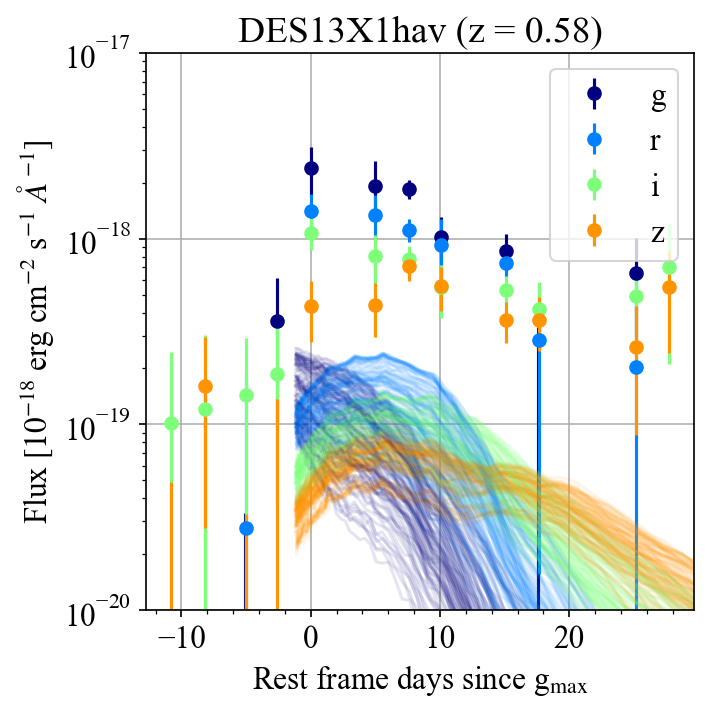

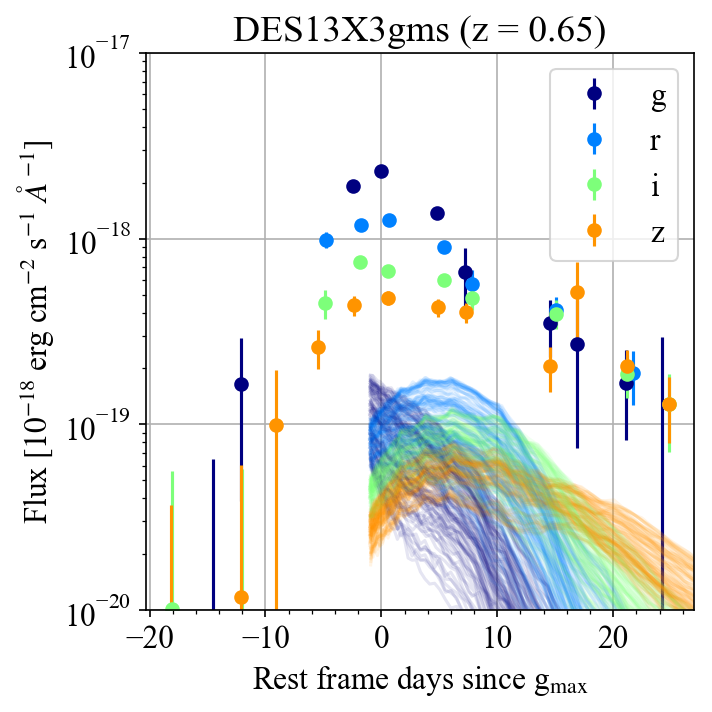

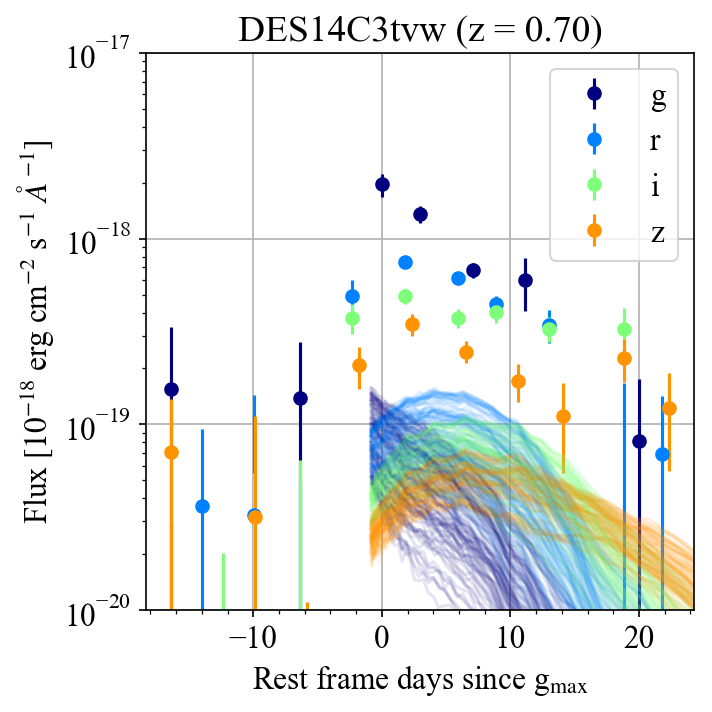

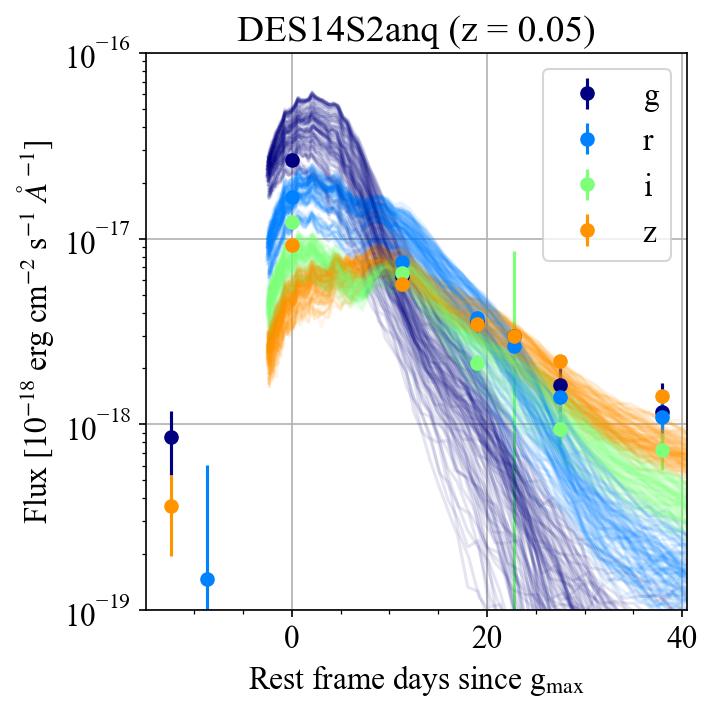

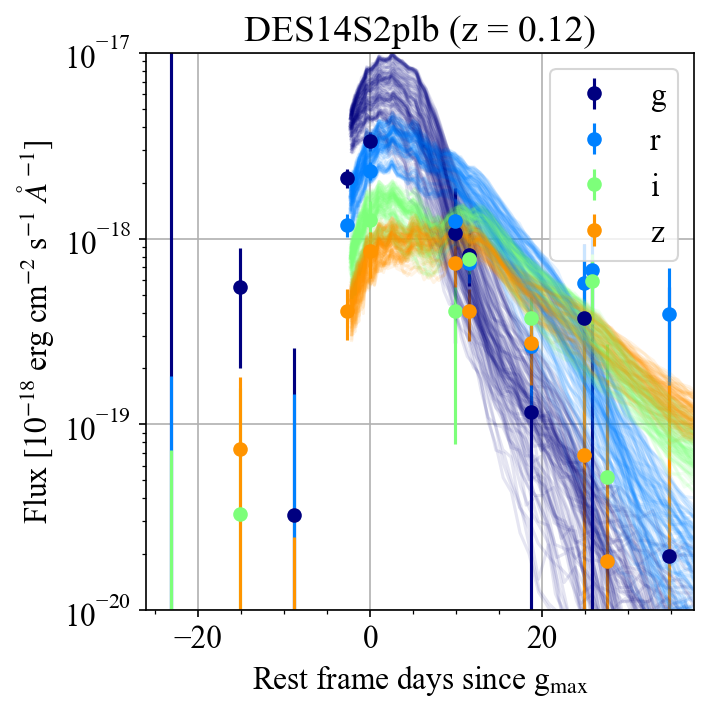

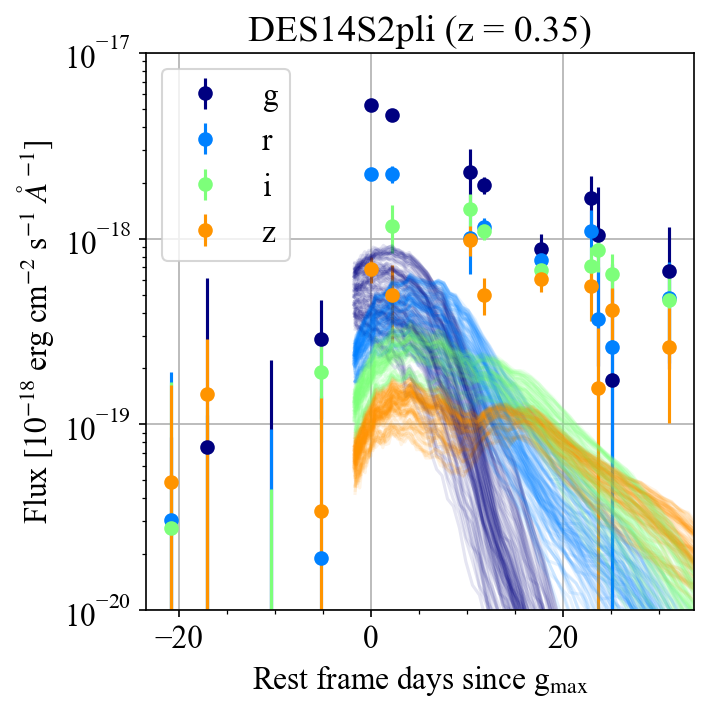

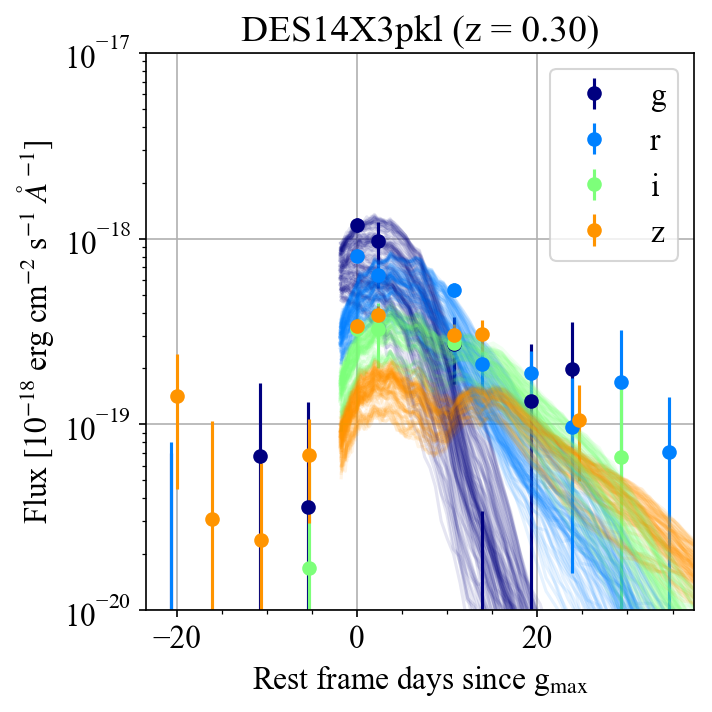

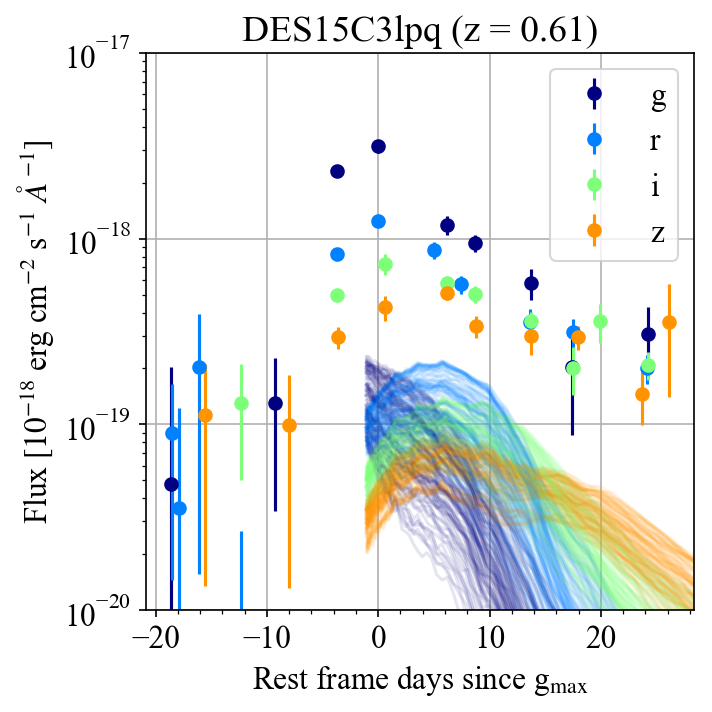

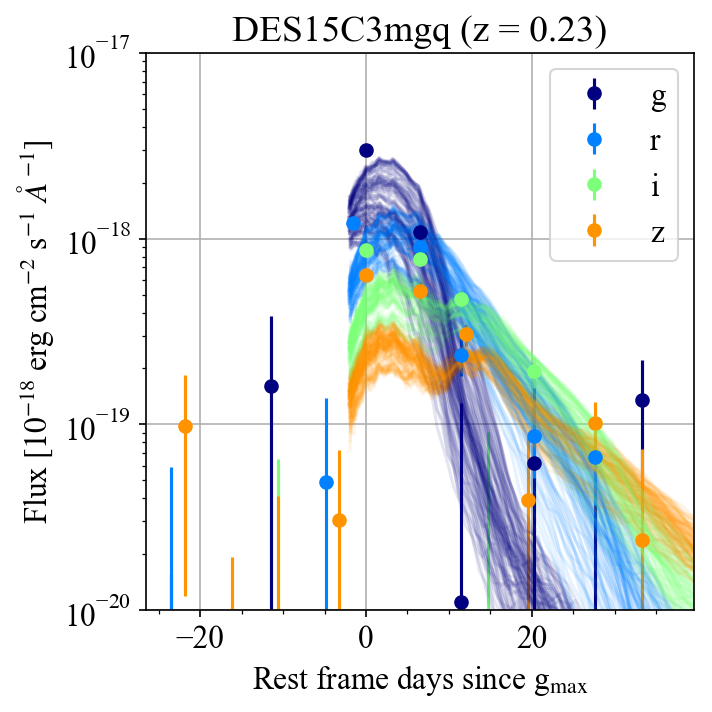

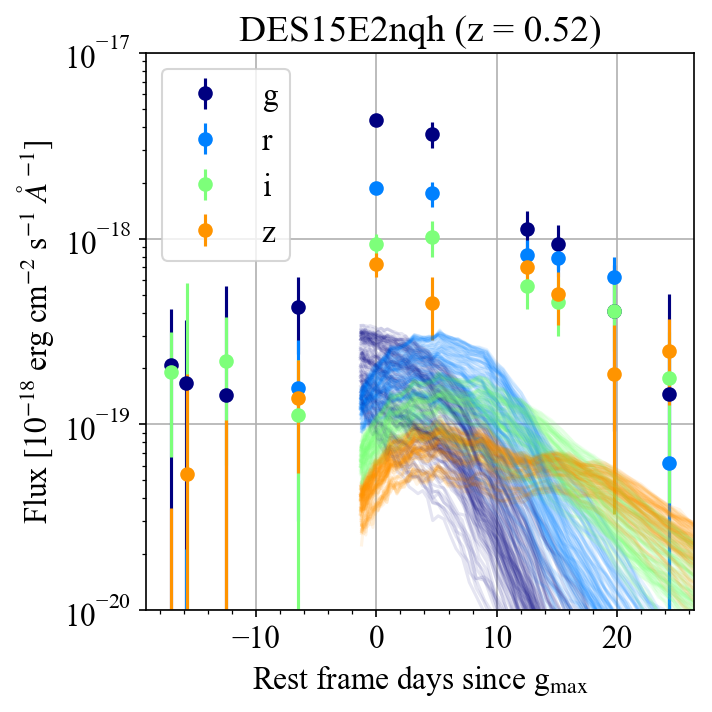

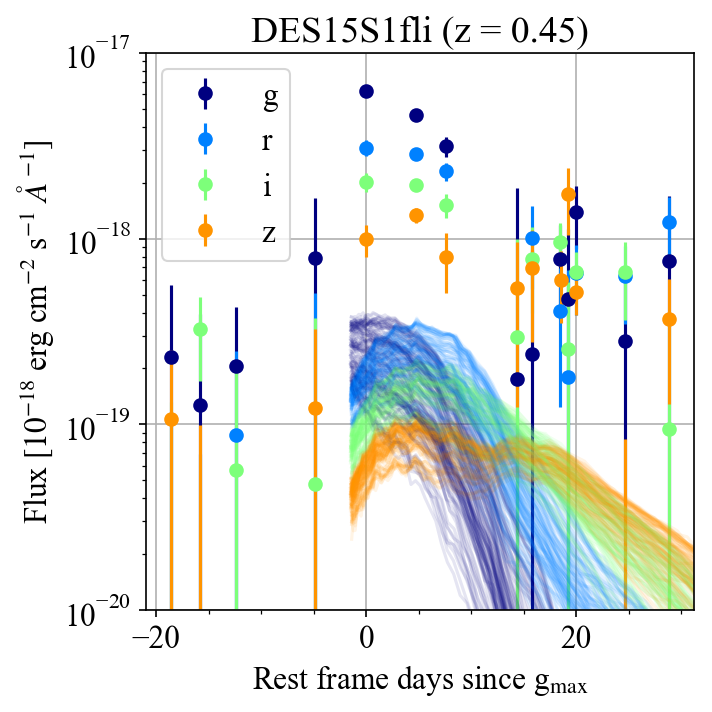

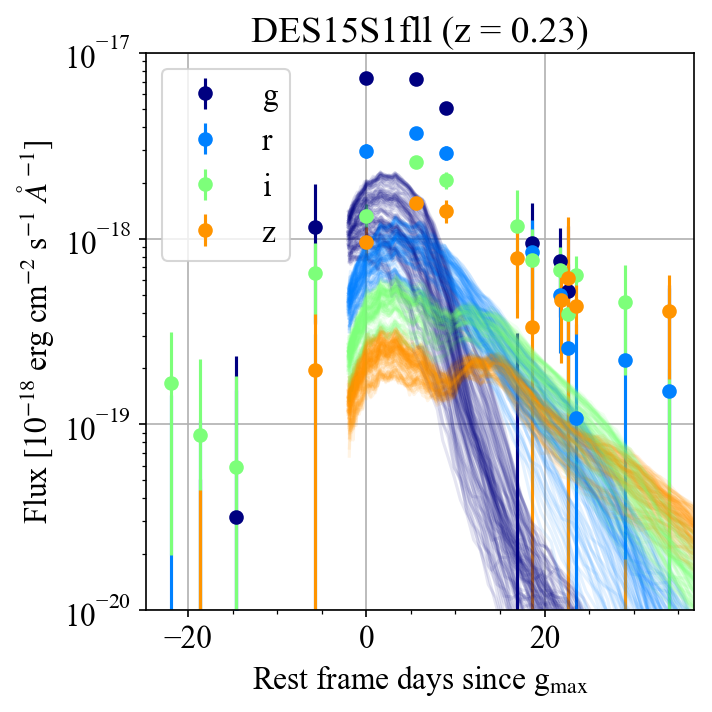

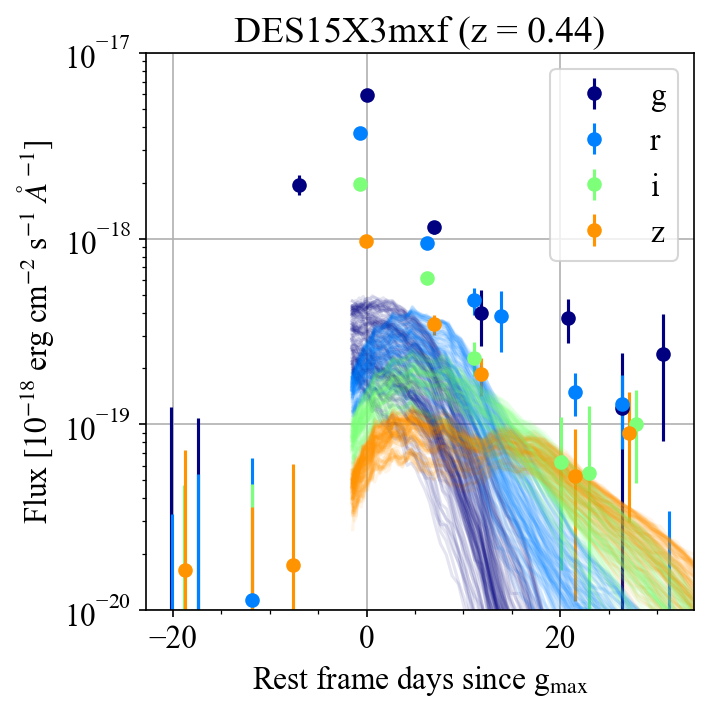

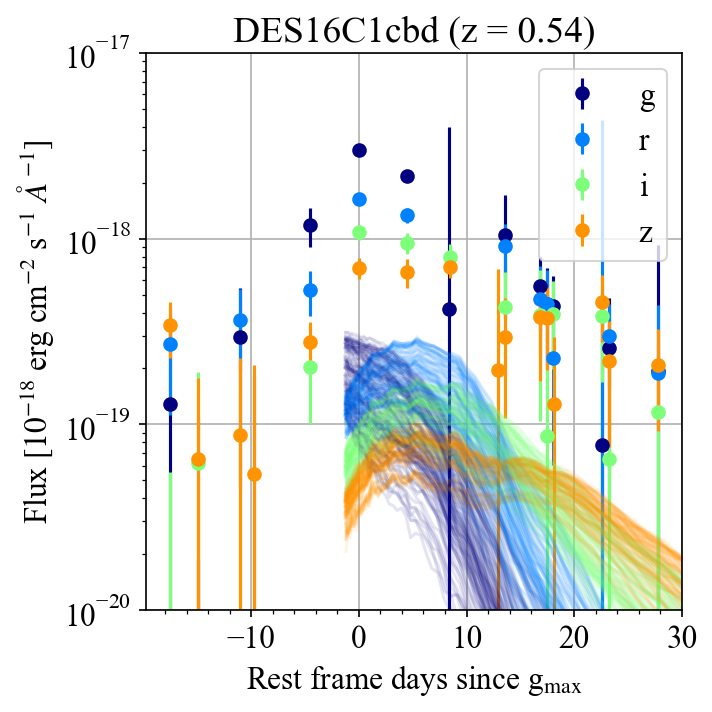

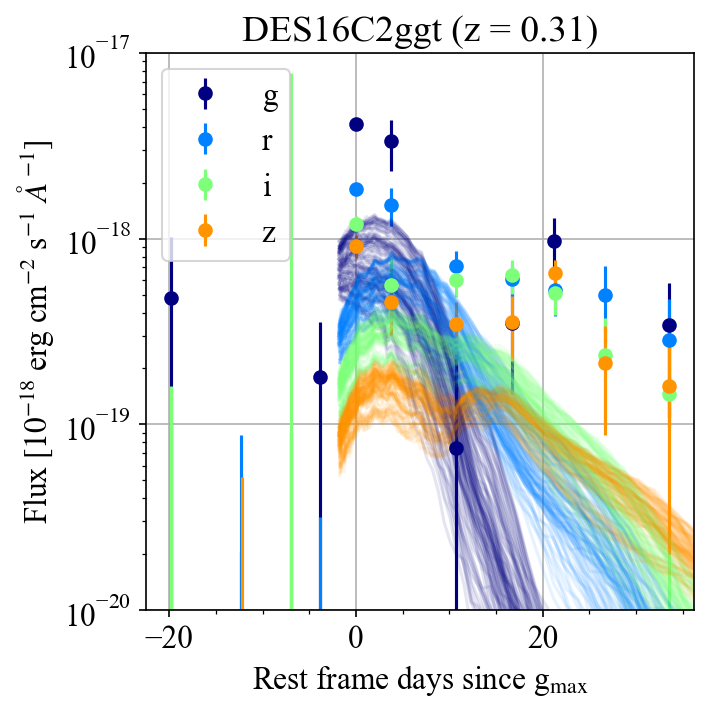

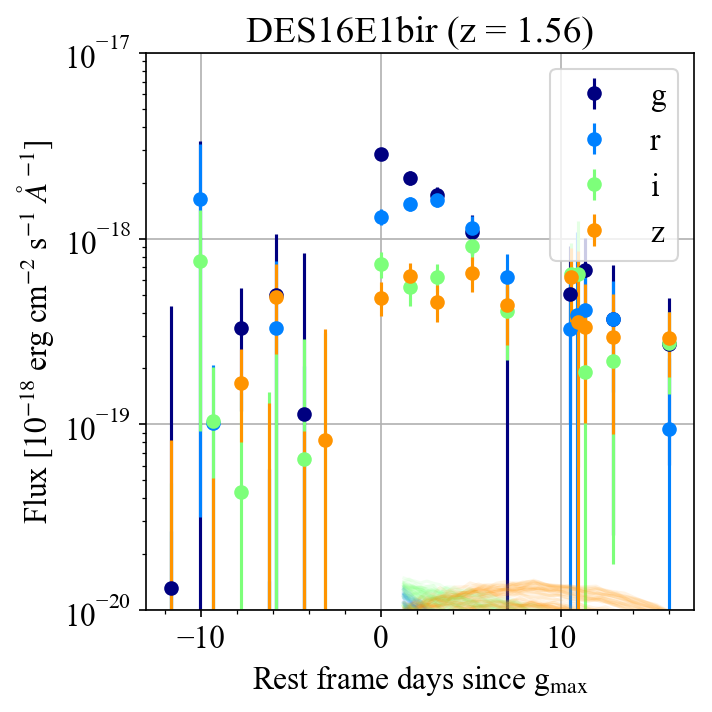

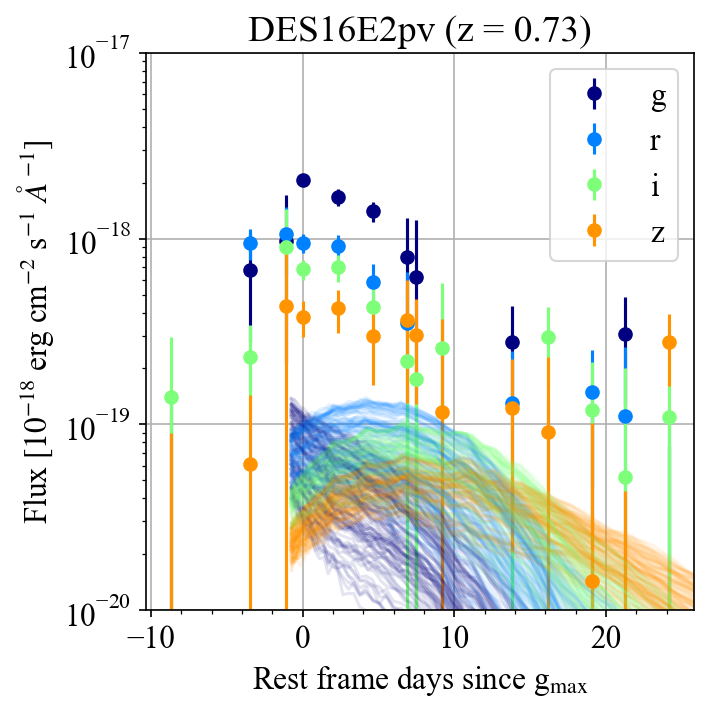

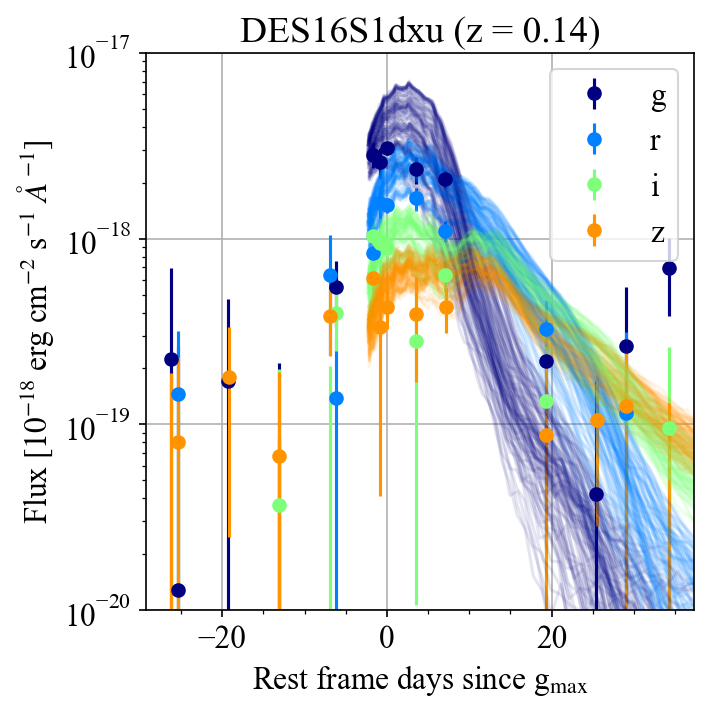

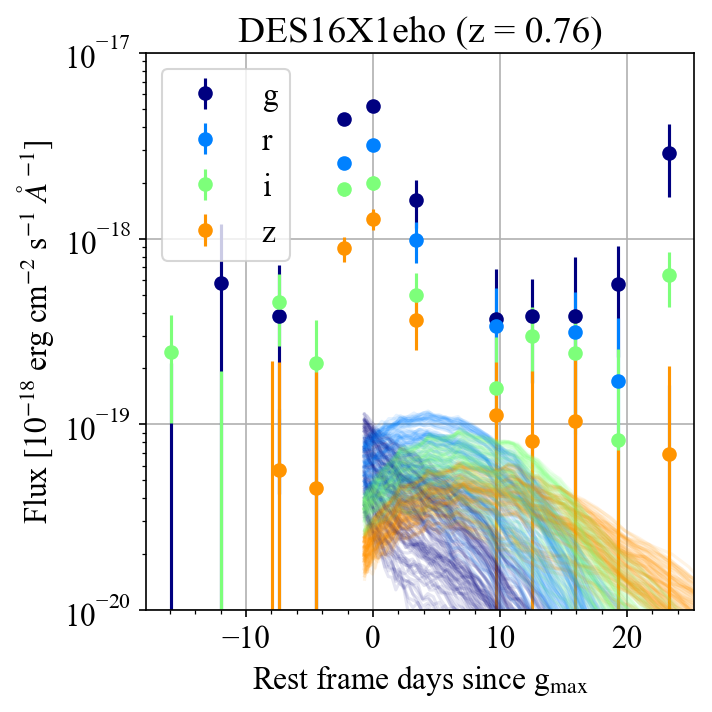

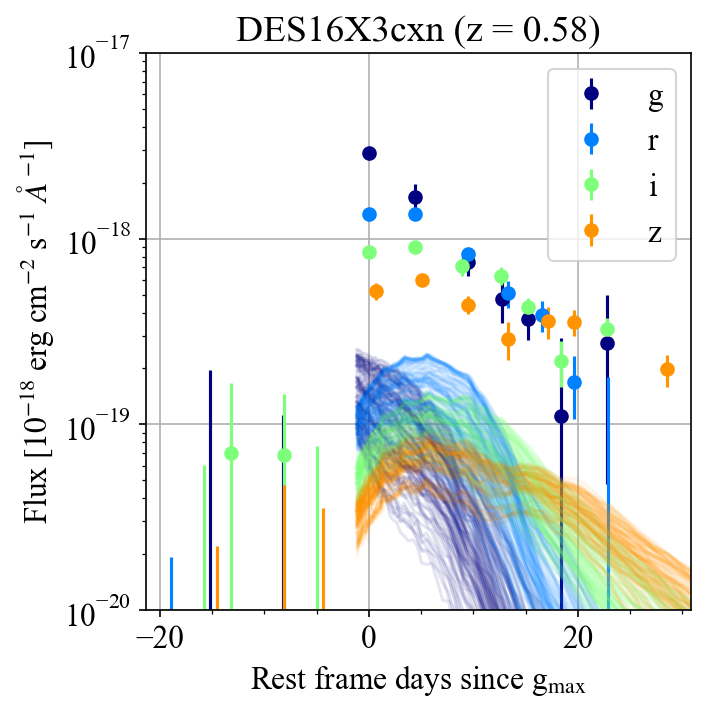

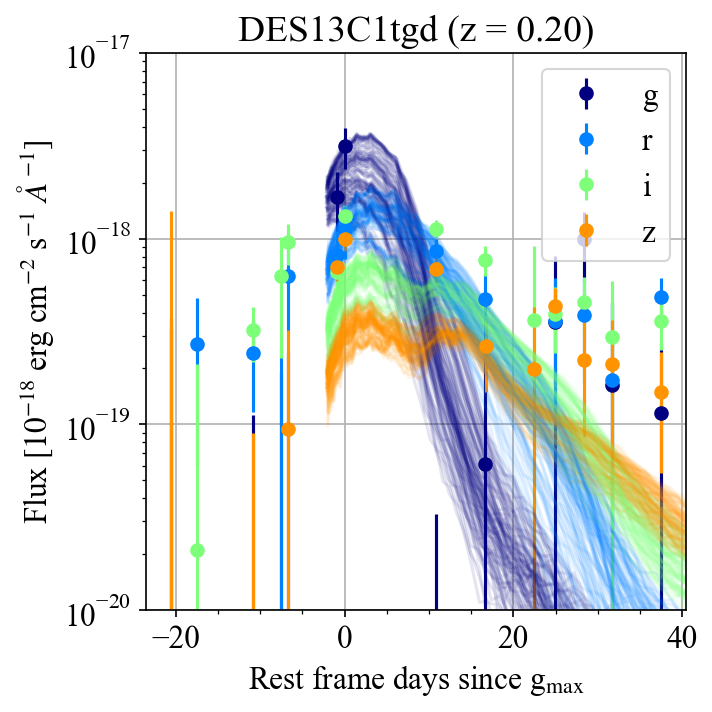

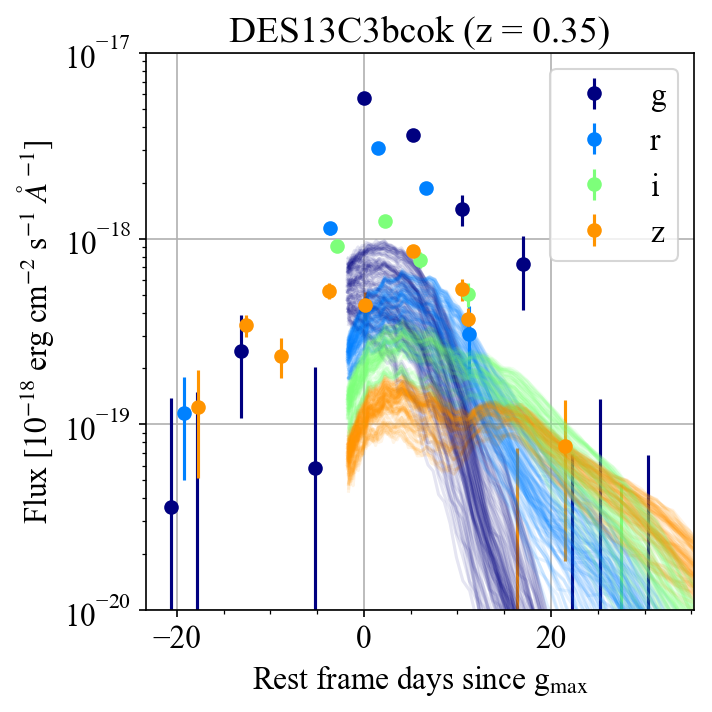

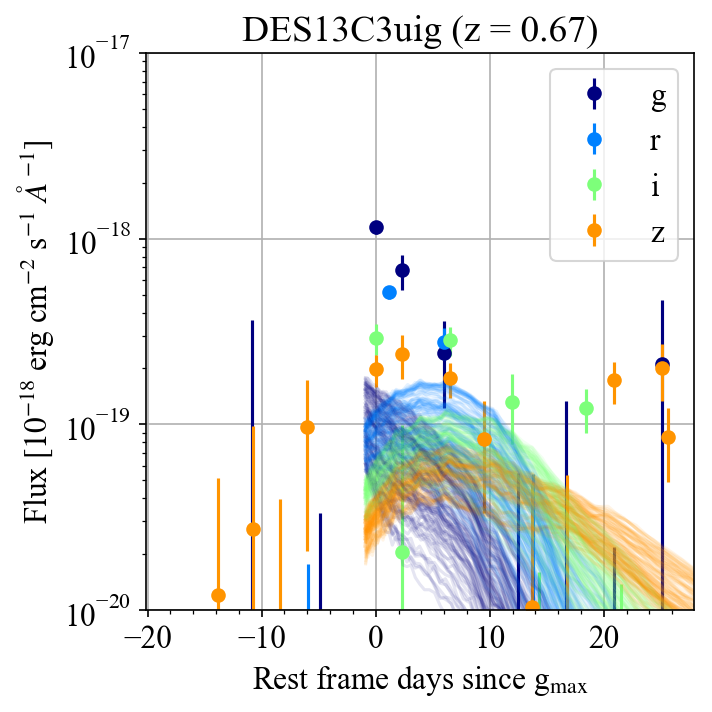

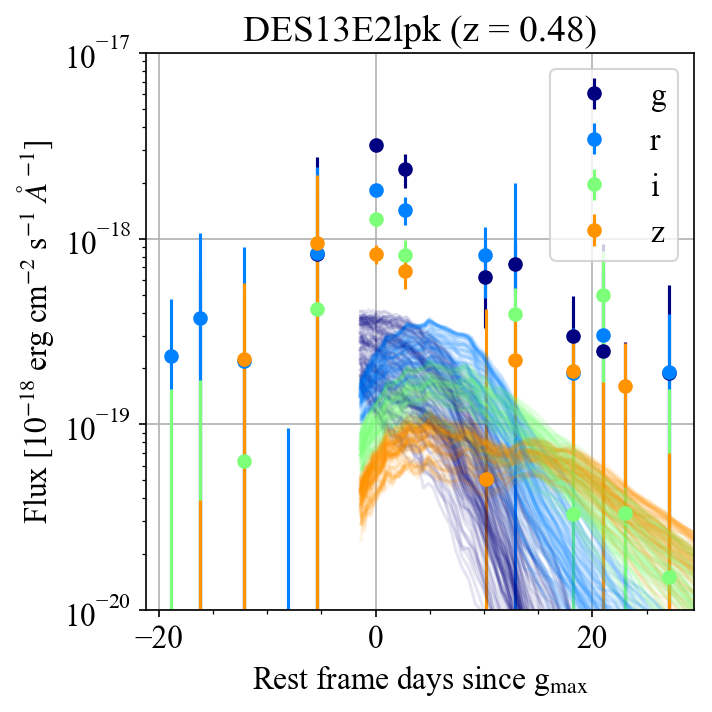

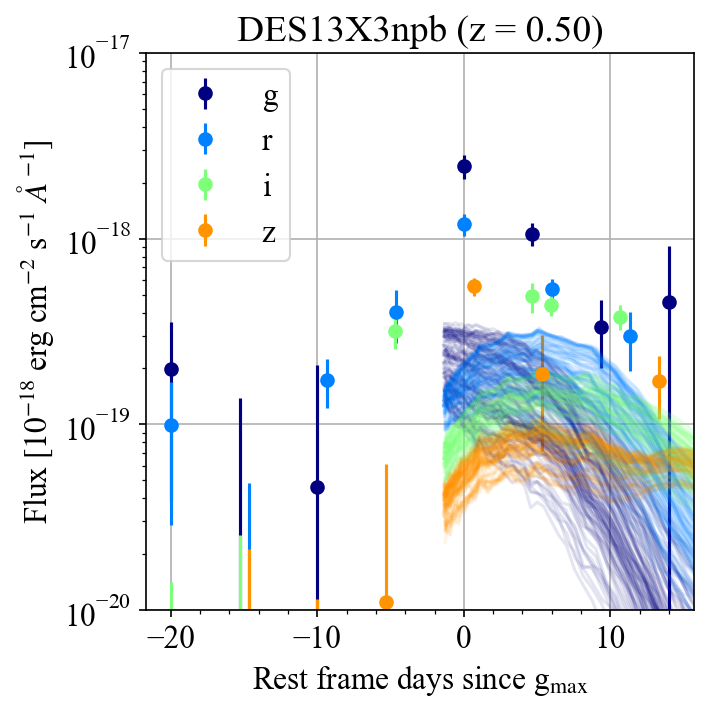

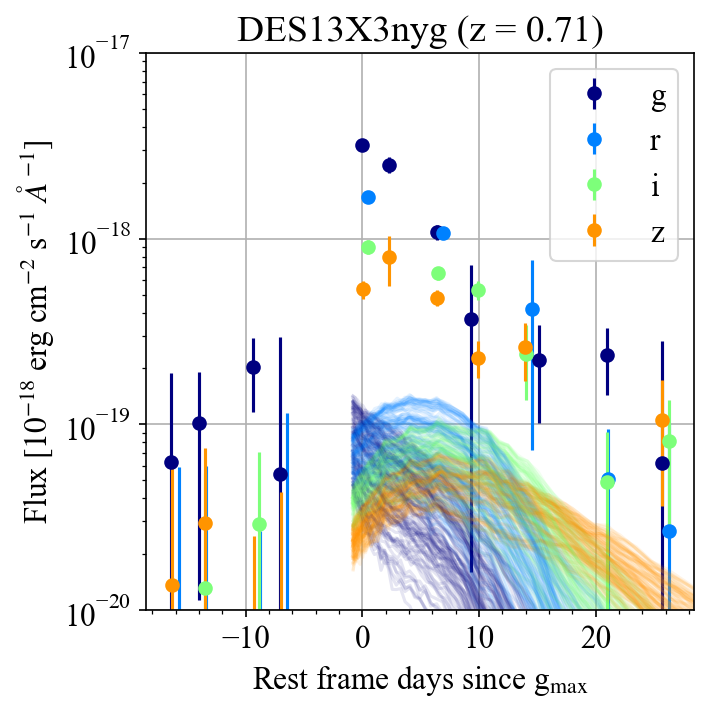

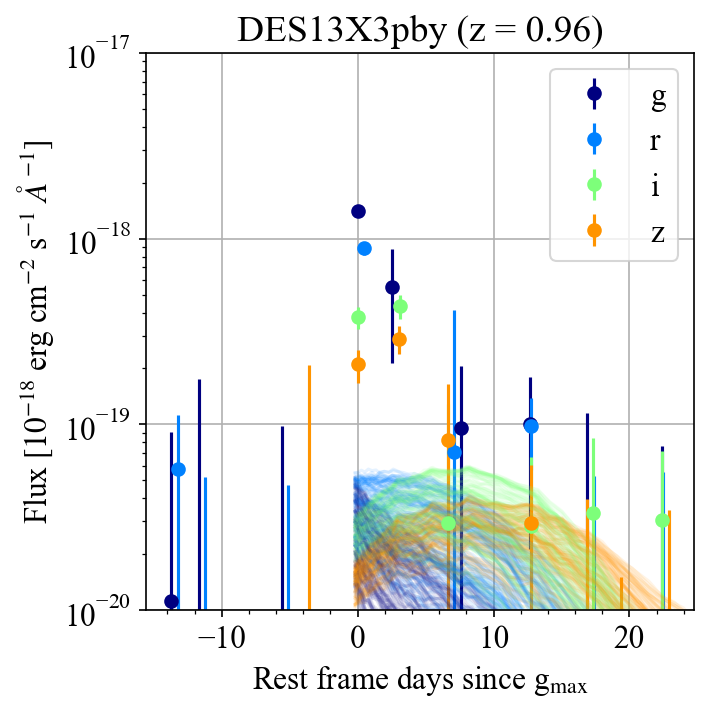

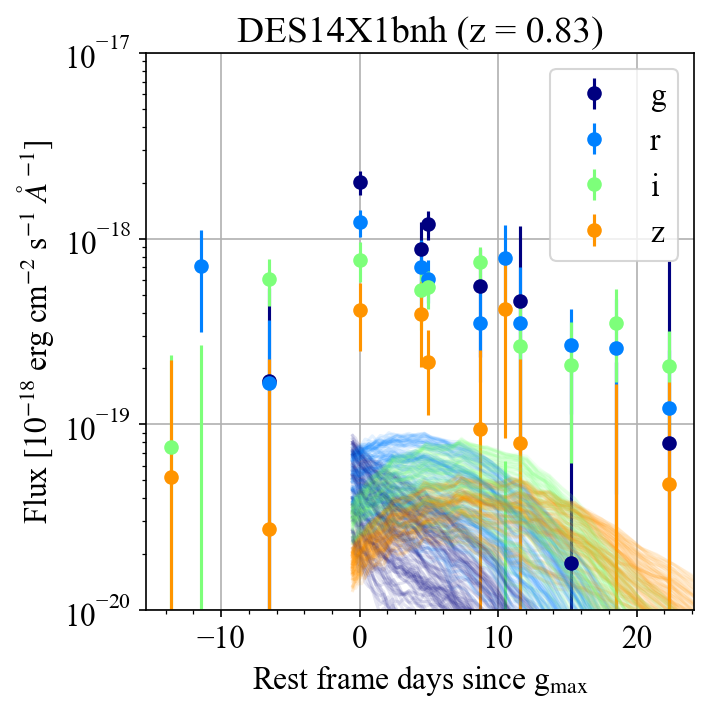

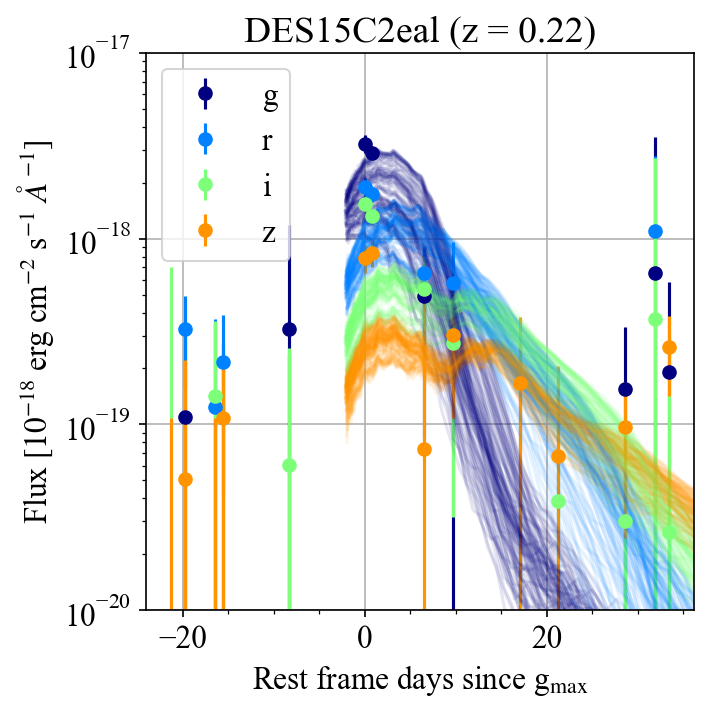

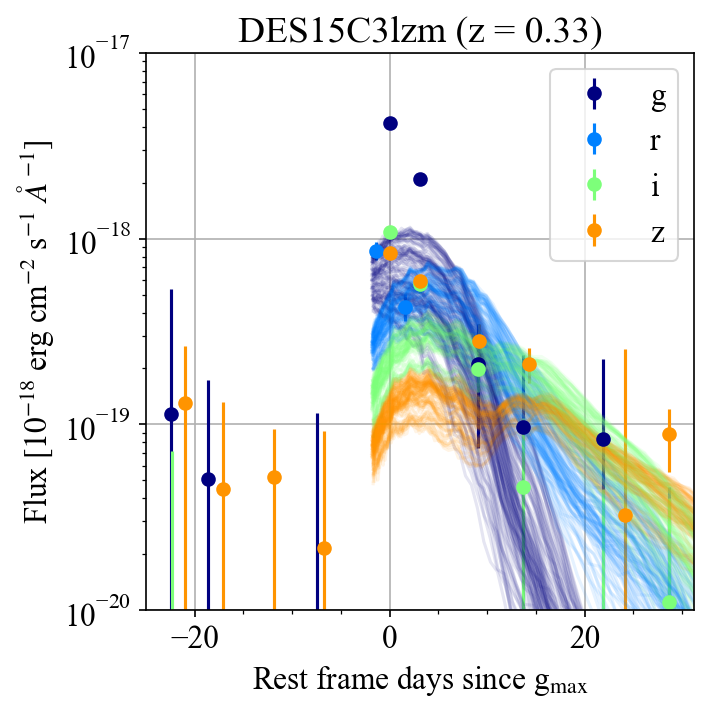

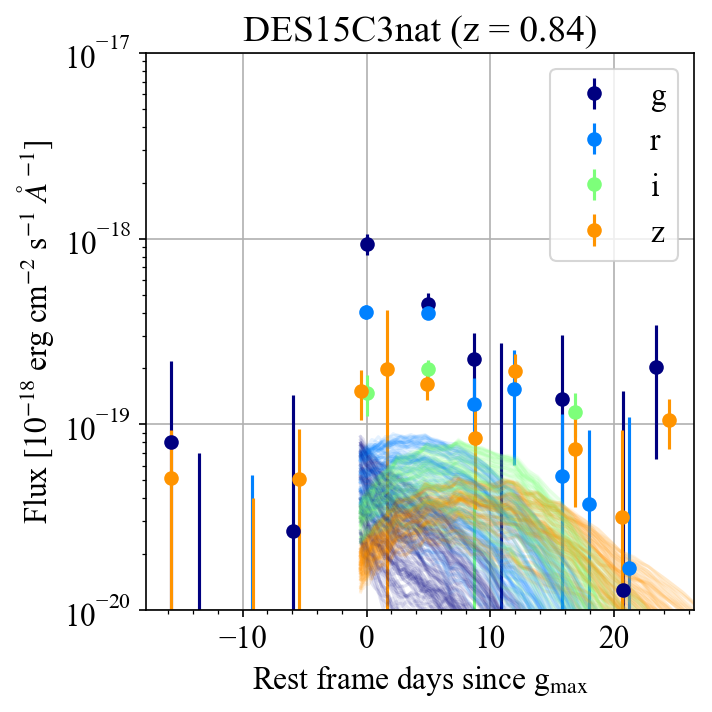

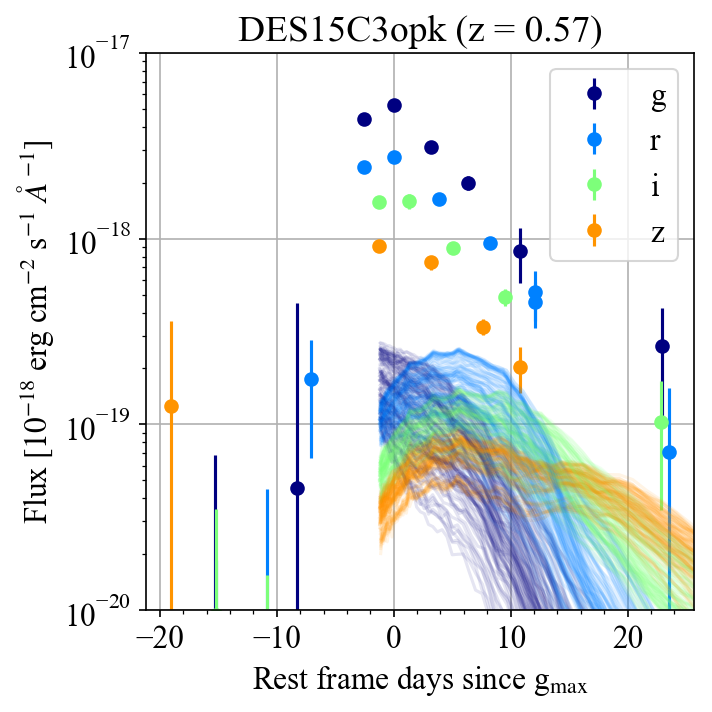

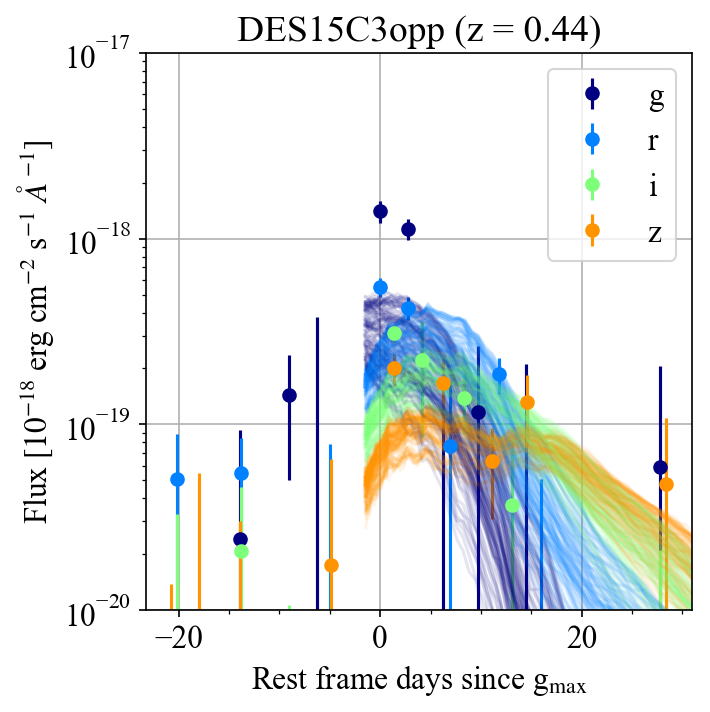

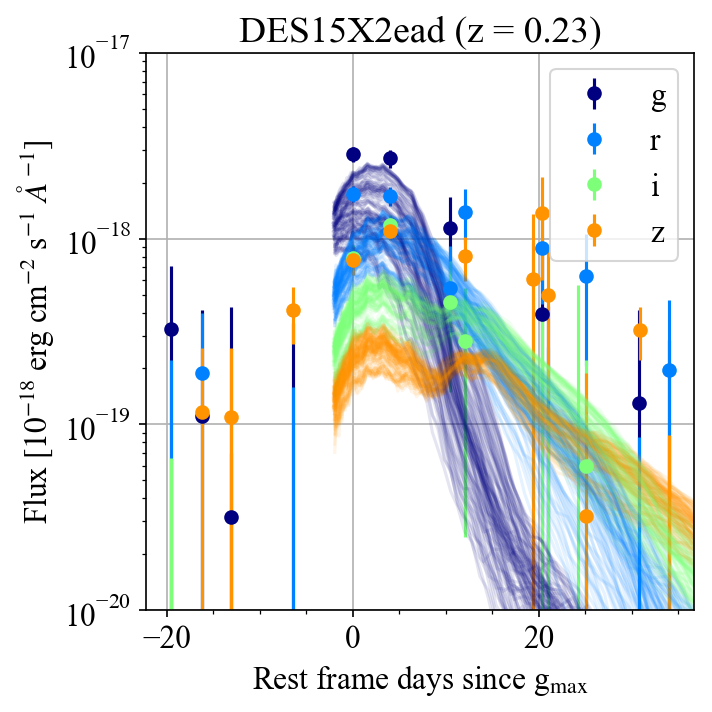

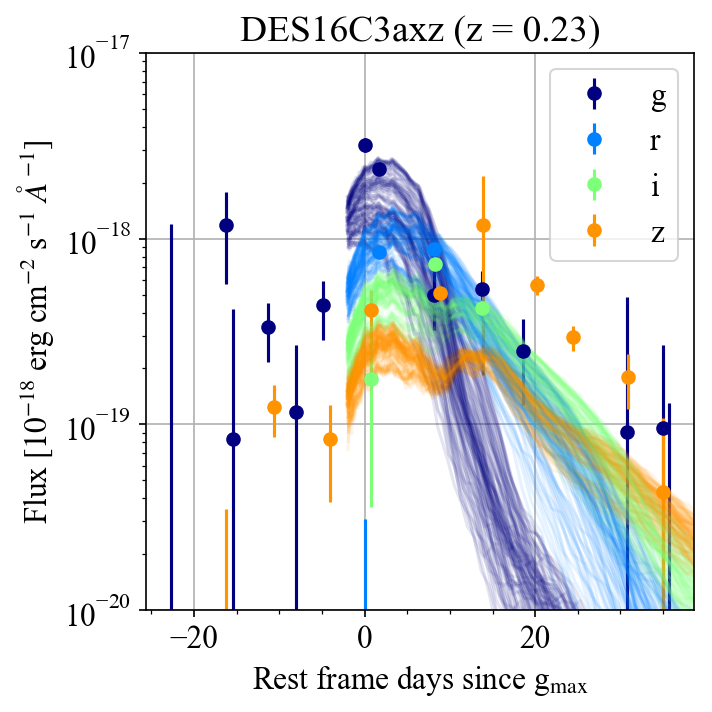

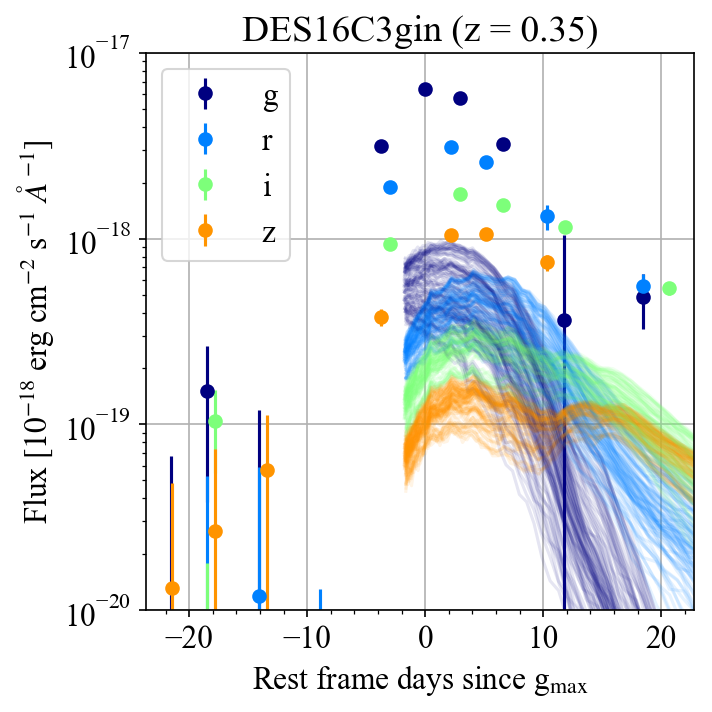

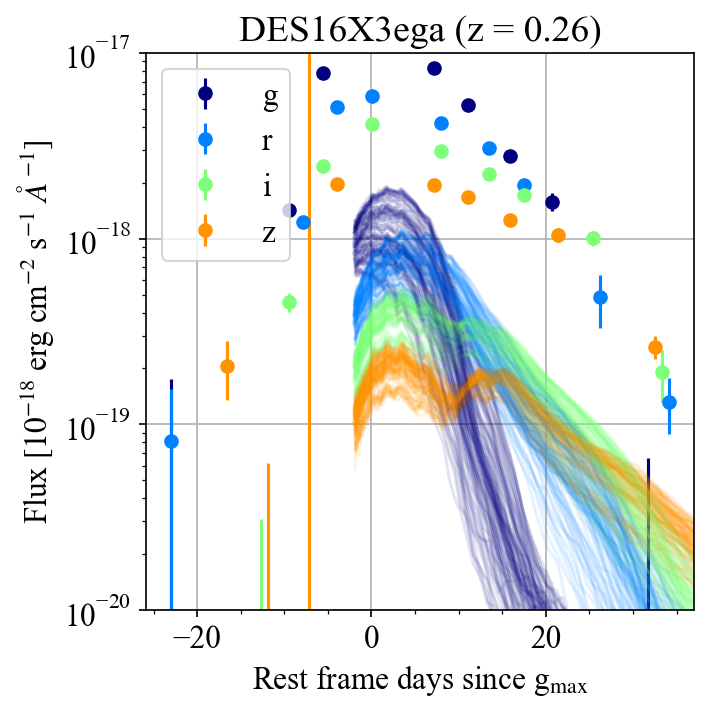

In [315]:
plt.close()

# for i in range(10,df_catalog_head.shape[0]):
for i in range(df_catalog_head.shape[0]):
#     if (i < 2):
    if (True):
        transient_ = read_decam_one_transient(df_catalog_head.loc[i, "name"], df_catalog_head, directory_light_curves=dir_catalog_lc, cosmo=astropy.cosmology.Planck15)
        transient_ = replace_MJD_to_rest_frame_day_after_peak(transient_)

        fig = plt.figure(figsize=(5,5))
#         fig = plt.figure()
        ax = plt.gca()

        plot_one_transient_obs_and_model(fig, ax, transient_, spectra_hewd, time_shift=5, alpha=0.1, savefig=True)


In [316]:
good_samples = np.array(["DES13C1tgd", "DES14S2anq", "DES14S2plb", "DES14X3pkl", "DES15C2eal", "DES16S1dxu"])

In [319]:
df_catalog_head["name"] 

0      DES13X1hav
1      DES13X3gms
2      DES14C3tvw
3      DES14S2anq
4      DES14S2plb
5      DES14S2pli
6      DES14X3pkl
7      DES15C3lpq
8      DES15C3mgq
9      DES15E2nqh
10     DES15S1fli
11     DES15S1fll
12     DES15X3mxf
13     DES16C1cbd
14     DES16C2ggt
15     DES16E1bir
16      DES16E2pv
17     DES16S1dxu
18     DES16X1eho
19     DES16X3cxn
20     DES13C1tgd
21    DES13C3bcok
22     DES13C3uig
23     DES13E2lpk
24     DES13X3npb
25     DES13X3nyg
26     DES13X3pby
27     DES14X1bnh
28     DES15C2eal
29     DES15C3lzm
30     DES15C3nat
31     DES15C3opk
32     DES15C3opp
33     DES15X2ead
34     DES16C3axz
35     DES16C3gin
36     DES16X3ega
Name: name, dtype: object

In [320]:
df_catalog_head

name  survey  offset(arcsec)  offset(kpc)   DLR  zspec  zphot  \
0    DES13X1hav   OzDES           0.381         2.51  0.90   0.58   0.64   
1    DES13X3gms   OzDES           0.879         6.09  1.13   0.65   0.64   
2    DES14C3tvw    ACES           3.703        26.46  3.71   0.70   0.70   
3    DES14S2anq    SDSS           0.377         0.37  0.34   0.05   0.08   
4    DES14S2plb   OzDES           1.506         3.26  1.82   0.12   0.13   
5    DES14S2pli   OzDES           1.623         8.01  2.24   0.35   0.39   
6    DES14X3pkl   OzDES           0.281         1.25  0.52   0.30   0.43   
7    DES15C3lpq   OzDES           0.323         2.18  0.44   0.61   0.62   
8    DES15C3mgq   OzDES           0.207         0.76  0.38   0.23   0.26   
9    DES15E2nqh   OzDES           0.517         3.22  1.41   0.52   0.46   
10   DES15S1fli   OzDES           0.771         4.44  0.81   0.45   0.46   
11   DES15S1fll   OzDES           2.997        11.01  3.50   0.23   0.21   
12   DES15X3mxf   OzDES           1.726         9.81  3.14   0.44   0.43   
13   DES16C1cbd   OzDES           1.075         6.83  1.21   0.54   0.54   
14   DES16C2ggt  PRIMUS           1.462         6.66  1.98   0.31   0.35   
15   DES16E1bir       –           0.341         2.89  1.11   1.56   0.53   
16    DES16E2pv   OzDES           1.081         7.85  1.84   0.73   0.82   
17   DES16S1dxu   OzDES           4.120        10.16  4.87   0.14   0.13   
18   DES16X1eho  PRIMUS           0.425         3.13  0.72   0.76   0.82   
19   DES16X3cxn   OzDES           0.626         4.12  1.00   0.58   0.64   
20   DES13C1tgd   OzDES           0.399         1.32  0.41   0.20   0.32   
21  DES13C3bcok     AAT           0.791         3.91  0.39   0.35   0.30   
22   DES13C3uig    ACES           0.542         3.80  0.78   0.67   0.66   
23   DES13E2lpk   OzDES           0.799         4.77  0.79   0.48   0.38   
24   DES13X3npb   OzDES           0.173         1.06  0.16   0.50   0.37   
25   DES13X3nyg   OzDES           0.410         2.95  0.75   0.71   0.68   
26   DES13X3pby   OzDES           0.337         2.67  0.75   0.96   0.41   
27   DES14X1bnh   OzDES           0.452         3.44  0.68   0.83   0.80   
28   DES15C2eal   OzDES           2.443         8.68  5.50   0.22   0.26   
29   DES15C3lzm   ATLAS           0.511         2.43  0.47   0.33   0.30   
30   DES15C3nat   OzDES           0.592         4.52  1.16   0.84   0.81   
31   DES15C3opk   OzDES           0.523         3.41  0.76   0.57   0.59   
32   DES15C3opp   OzDES           0.429         2.44  0.83   0.44   0.37   
33   DES15X2ead   OzDES           0.545         2.00  0.65   0.23   0.25   
34   DES16C3axz     AAT           0.336         1.23  0.44   0.23   0.21   
35   DES16C3gin   OzDES           1.606         7.93  1.87   0.35   0.41   
36   DES16X3ega    GAMA           2.219         8.93  2.17   0.26   0.19   

      RA(J2000)    Dec(J2000)    Eb_v  
0   02:20:07.80  −05:06:36.53  0.0185  
1   02:23:12.27  −04:29:38.35  0.0246  
2   03:33:17.61  −27:54:23.92  0.0058  
3   02:45:06.67  −00:44:42.77  0.0294  
4   02:47:25.62  −01:37:06.91  0.0369  
5   02:44:54.76  −01:05:52.74  0.0256  
6   02:28:50.64  −04:48:26.44  0.0332  
7   03:30:50.89  −28:36:47.08  0.0078  
8   03:31:04.56  −28:12:31.74  0.0080  
9   00:38:55.59  −43:05:13.14  0.0076  
10  02:52:45.15  −00:53:10.21  0.0675  
11  02:51:09.36  −00:11:48.71  0.0611  
12  02:26:57.72  −05:14:22.81  0.0237  
13  03:39:25.97  −27:40:20.37  0.0100  
14  03:35:33.88  −29:13:29.33  0.0089  
15  00:30:58.64  −42:58:37.18  0.0064  
16  00:36:50.19  −43:31:40.16  0.0059  
17  02:50:43.53  −00:42:33.29  0.0486  
18  02:21:22.87  −04:31:32.64  0.0229  
19  02:27:19.32  −04:57:04.27  0.0234  
20  03:36:15.42  −27:38:19.07  0.0105  
21  03:32:06.47  −28:37:29.70  0.0081  
22  03:31:46.55  −27:35:07.96  0.0073  
23  00:40:23.80  −43:32:19.74  0.0058  
24  02:26:34.11  −04:08:01.96  0.0242  
25  02:27:58.17  −03:54:48.05  0.0233  
26  02:25:19.98  −05:18:50.58  0.0223  
27

In [336]:
print("good samples")
df_catalog_head_good = df_catalog_head.query("name in @good_samples")
df_catalog_head_good

good samples


name survey  offset(arcsec)  offset(kpc)   DLR  zspec  zphot  \
3   DES14S2anq   SDSS           0.377         0.37  0.34   0.05   0.08   
4   DES14S2plb  OzDES           1.506         3.26  1.82   0.12   0.13   
6   DES14X3pkl  OzDES           0.281         1.25  0.52   0.30   0.43   
17  DES16S1dxu  OzDES           4.120        10.16  4.87   0.14   0.13   
20  DES13C1tgd  OzDES           0.399         1.32  0.41   0.20   0.32   
28  DES15C2eal  OzDES           2.443         8.68  5.50   0.22   0.26   

      RA(J2000)    Dec(J2000)    Eb_v  
3   02:45:06.67  −00:44:42.77  0.0294  
4   02:47:25.62  −01:37:06.91  0.0369  
6   02:28:50.64  −04:48:26.44  0.0332  
17  02:50:43.53  −00:42:33.29  0.0486  
20  03:36:15.42  −27:38:19.07  0.0105  
28  03:36:14.68  −29:13:49.32  0.0086

In [332]:
df_catalog_head["DLR"]

0     0.90
1     1.13
2     3.71
3     0.34
4     1.82
5     2.24
6     0.52
7     0.44
8     0.38
9     1.41
10    0.81
11    3.50
12    3.14
13    1.21
14    1.98
15    1.11
16    1.84
17    4.87
18    0.72
19    1.00
20    0.41
21    0.39
22    0.78
23    0.79
24    0.16
25    0.75
26    0.75
27    0.68
28    5.50
29    0.47
30    1.16
31    0.76
32    0.83
33    0.65
34    0.44
35    1.87
36    2.17
Name: DLR, dtype: float64

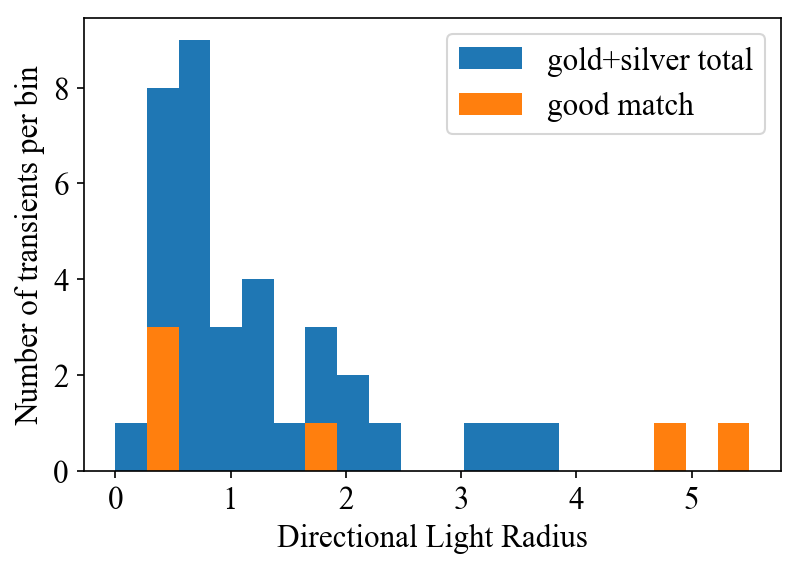

In [343]:
plt.hist(df_catalog_head["DLR"], bins=np.linspace(0,5.5,21), label="gold+silver total")
plt.hist(df_catalog_head_good["DLR"], bins=np.linspace(0,5.5,21), label="good match")
plt.xlabel("Directional Light Radius")
plt.ylabel("Number of transients per bin")
plt.legend()